## Book analysis.

The following paper will present the analysis on book sales (unit sold) based on the 
following features: genre, publisher_name, publisher_type, average_rating, sales_rank, sale_price and 
total_reviews. 

Moreover, we will look to the book rating dataset which includes author name to see how much
effect big name authors influence the rating. 

The below analysis will be using 3 set of data:
1. [publishers](https://corgis-edu.github.io/corgis/csv/publishers/)
2. [BX-Book-Rating](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)
3. [BX-Books](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

After cleaning, publisher (sales) will contain all sale data while 2 BX dataset will be combined
into one (rating) that contains characteristic and rating for books.

#### Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

#### Load and Clean data

We want the sales dataframe with sale data and rating with books information and rating data.

#### Sales data

In [2]:
# Publisher dataset 
data_path = 'D:\\PycharmProjects\\springboard\\data\\'
sales = pd.read_csv(f'{data_path}publishers.csv')

# Replace dot and space in columns name. Remove the word statistic in column name
sales.columns = sales.columns.str.replace(r'[\.\s]', '_').str.replace('statistics_', '')

# Remove multiple revenues and gross sales columns as these will create Multicollinearity 
# We only want units_sold in this case
sales = sales.drop(sales.columns[2:6], axis=1)
sales = sales.drop('sales_rank', axis=1)

# Save the cleaned data
sales.to_csv(f'{data_path}book_sales.csv')

# First look
print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27027 entries, 0 to 27026
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   genre                     27027 non-null  object 
 1   sold_by                   27027 non-null  object 
 2   daily_average_units_sold  27027 non-null  int64  
 3   publisher_name            27027 non-null  object 
 4   publisher_type            27027 non-null  object 
 5   average_rating            27027 non-null  float64
 6   sale_price                27027 non-null  float64
 7   total_reviews             27027 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 1.6+ MB
None


,genre,sold_by,daily_average_units_sold,publisher_name,publisher_type,average_rating,sale_price,total_reviews
0,genre fiction,HarperCollins Publishers,7000,Katherine Tegen Books,big five,4.57,4.88,9604
1,genre fiction,HarperCollins Publishers,6250,HarperCollins e-books,big five,4.47,1.99,450
2,genre fiction,"Amazon Digital Services, Inc.",5500,(Small or Medium Publisher),small/medium,4.16,8.69,30
3,fiction,Hachette Book Group,5500,"Little, Brown and Company",big five,3.84,7.50,3747
4,genre fiction,Penguin Group (USA) LLC,4750,Dutton Children's,big five,4.75,7.99,9174


#### Books and reviews data

In [3]:
# Load books data set and clean up column names. Omitted last 3 columns since they are
# links only
books = pd.read_csv(f'{data_path}BX-Books.csv', sep=';', error_bad_lines=True,
                    usecols=[0,1,2,3,4], encoding='ISO-8859-1', index_col='ISBN',
                    low_memory=False)
books.columns = books.columns.str.lower().str.replace('-','_')

# Count
print(books.count())

book_title             271379
book_author            271378
year_of_publication    271379
publisher              271377
dtype: int64


There are multiples reviews of the same book (isbn) from different users. Thus, we will
get the mean rating as the metric to merge into books reviews.

In [4]:
# Load reviews data. We also lower case and snake_case column names
reviews = pd.read_csv(f'{data_path}BX-Book-Ratings.csv', sep=';', error_bad_lines=True,
                      encoding='ISO-8859-1', usecols=[1,2])
reviews.columns = reviews.columns.str.lower().str.replace('-', '_')

# Group by isbn and get mean rating
reviews = reviews.groupby('isbn').mean()

# print info on reviews
print(reviews.count())

book_rating    340556
dtype: int64


In [5]:
# Merge books and reviews on isbn. Leave reviews without the isbn
rating = pd.merge(books, reviews, how='left', left_index=True, right_index=True)

# save for future use
rating.to_csv(f'{data_path}book_rating.csv')

# first look
rating.info()
rating.head()

<class 'pandas.core.frame.DataFrame'>
Index: 271379 entries, 0195153448 to 0767409752
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   book_title           271379 non-null  object 
 1   book_author          271378 non-null  object 
 2   year_of_publication  271379 non-null  object 
 3   publisher            271377 non-null  object 
 4   book_rating          270170 non-null  float64
dtypes: float64(1), object(4)
memory usage: 22.4+ MB


,book_title,book_author,year_of_publication,publisher,book_rating
ISBN,,,,,
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,0.000000
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,4.928571
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,5.000000
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,4.272727
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,0.000000


In [6]:
# Clear out unused data frames
del books
del reviews

#### Exploratory data analysis

##### Sale Price

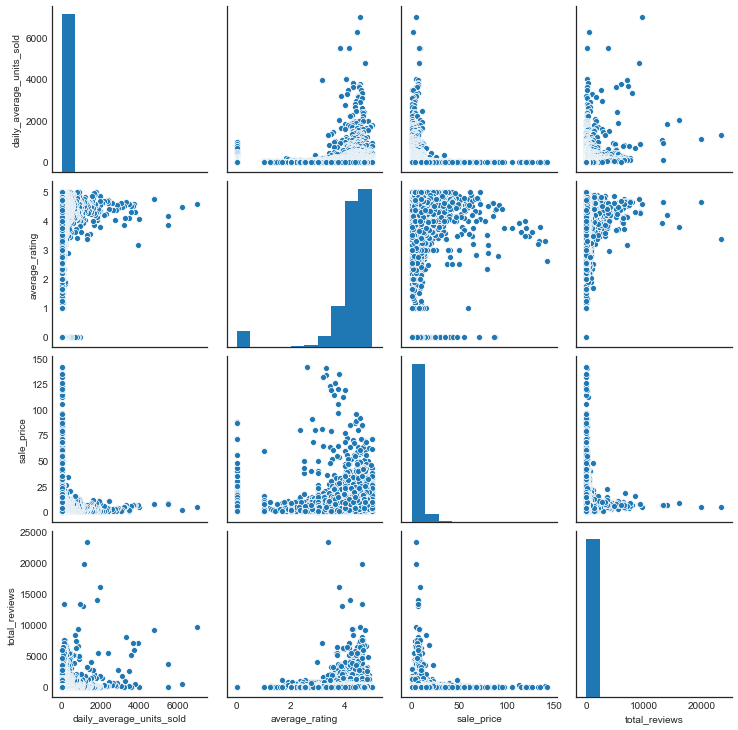

In [7]:
# Pair plot
sns.pairplot(sales)

Text(0.5, 1.0, 'Price vs Unit sold')

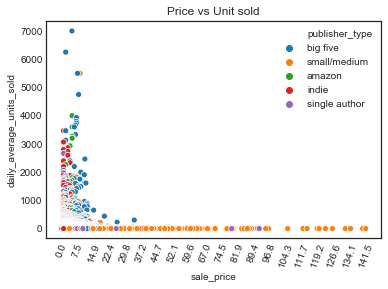

In [8]:
# Price and unit sold break down by publisher type
sns.scatterplot(x='sale_price', y='daily_average_units_sold', data=sales, 
                hue='publisher_type')
plt.xticks(np.linspace(sales.sale_price.min(), sales.sale_price.max(),num=20), rotation=70)
plt.title('Price vs Unit sold')

While there are many expensive books which is price at over $50, the majority of books
are affordable (median = $5.12).

Moreover, all books published by amazon are all under $20.

In [9]:
# Median sale price
print('Median book price:', sales.sale_price.median())
print('Mean book price:', sales.sale_price.mean())

Median book price: 5.12
Mean book price: 6.777487697487698


Text(0.5, 1.0, 'Box plot of sale price separated by publisher_type')

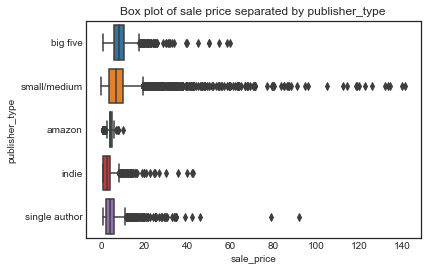

In [10]:
# Sale price box plot
sns.boxplot(x='sale_price', y='publisher_type', data=sales)
plt.title('Box plot of sale price separated by publisher_type')

Text(0.5, 1.0, 'Book sale price distribution')

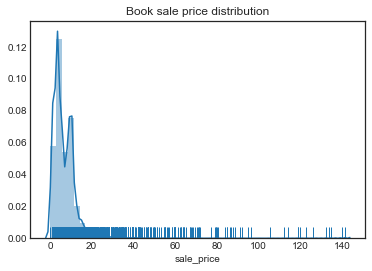

In [11]:
# Sale price distribution
sns.distplot(sales.sale_price, kde=True, rug=True)
plt.title('Book sale price distribution')

Lets take a look at books publisher broken down through a price range.

In [12]:
for price in [20, 40, 80, 100]:
    print(f'Price over ${price}\n', 
          sales[sales.sale_price > price].publisher_type.value_counts(), '\n\n')
    

Price over $20
 small/medium     441
big five          46
single author     31
indie             10
Name: publisher_type, dtype: int64 


Price over $40
 small/medium     97
big five          6
single author     4
indie             2
Name: publisher_type, dtype: int64 


Price over $80
 small/medium     25
single author     1
Name: publisher_type, dtype: int64 


Price over $100
 small/medium    13
Name: publisher_type, dtype: int64 




##### Ratings

There is no apparent relationship between total reviews and unit sold even when we
control for outliers. This is troublesome since it will greatly decrease the usefulness
of our second dataset. 

However, high count of reviews is not high rating. Thus, the amount of reviews may be 
correlated to other factor such as time since published and genre. 

Text(0.5, 1.0, 'units_sold vs total_reviews')

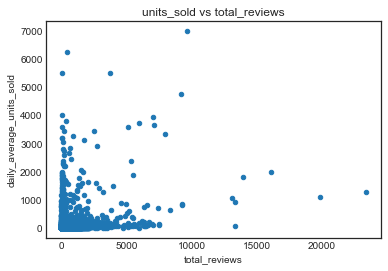

In [13]:
# Total review versus unit sold
sales.plot(kind='scatter', y='daily_average_units_sold', x='total_reviews')
plt.title('units_sold vs total_reviews')

Text(0.5, 1.0, 'units_sold vs total_reviews (<4000)')

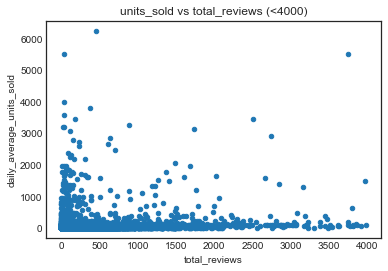

In [14]:
# Total review (<4000) versus unit sold
sales[sales.total_reviews < 4000].plot(kind='scatter', y='daily_average_units_sold', x='total_reviews')
plt.title('units_sold vs total_reviews (<4000)')

In [15]:
# Total review and genre
sales.genre.value_counts()

nonfiction          14161
genre fiction        8903
children             2541
fiction               733
comics                568
foreign language      121
Name: genre, dtype: int64

Taking a quick look into genre of sale data, we see again there are so many observations
that are out of normal range. All this behavior strongly suggest that bestsellers makes
up the bulk of big money in book sale. There are hundreds of thousands of books but
perhaps only the small fraction of bestsellers enjoy the majority of the revenue.

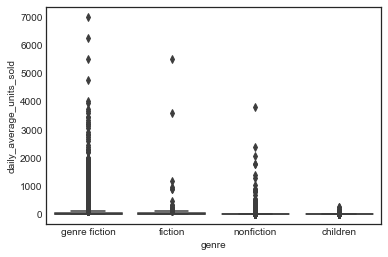

In [16]:
# Violin plot of units sold broken down by genre.
# Excluding Comics and foreign language because of their small volume. 
sns.boxplot(x='genre', y='daily_average_units_sold', 
            data=sales.loc[(sales.genre != 'comics') & (sales.genre != 'foreign language')])

A majority of books has a good average rating of over 4. However, fiction and genre
fictions makes up the majority of sales. 

There is a subgroup that has zero average rating. We should take a look at these to 
see why

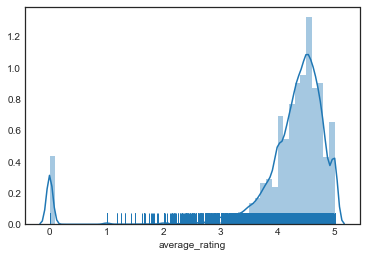

In [17]:
# Rating Distribution
sns.distplot(sales.average_rating, kde=True, rug=True)

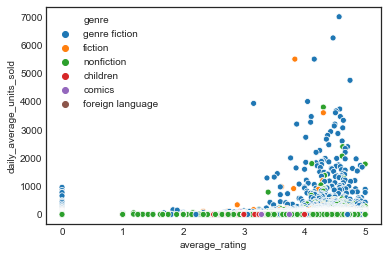

In [18]:
# Average rating vs units_sold
sns.scatterplot(x='average_rating', y='daily_average_units_sold', data=sales,
                hue='genre')


